In [1]:
# Configuring the path of kaggle file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d jangedoo/utkface-new

 99% 329M/331M [00:11<00:00, 35.9MB/s]
100% 331M/331M [00:11<00:00, 31.1MB/s]


In [3]:
# Extracting the zip dataset

from zipfile import ZipFile
dataset = "/content/utkface-new.zip"

with ZipFile(dataset,"r") as zip:
  zip.extractall()
  print("Extraction complete")

Extraction complete


In [4]:
import os
import numpy as np
import pandas as pd
import random

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet  import ResNet50
from keras.layers import *
from keras.utils import plot_model
from keras.models import Model

In [5]:
path = "/content/utkface_aligned_cropped/UTKFace"

In [6]:
age = []
gender = []
img_path = []

In [7]:
for file in os.listdir(path):
  print(file)
  break

54_0_0_20170111201637797.jpg.chip.jpg


In [8]:
for file in os.listdir(path):
  age.append(int(file.split("_")[0]))
  gender.append(int(file.split("_")[1]))
  img_path.append(file)

In [9]:
len(age)

23708

In [10]:
len(gender)

23708

In [11]:
len(img_path)

23708

In [12]:
df = pd.DataFrame({"age":age,"gender":gender,"img":img_path})

In [13]:
df.head()

,age,gender,img
0,54,0,54_0_0_20170111201637797.jpg.chip.jpg
1,22,1,22_1_2_20161219153940196.jpg.chip.jpg
2,24,1,24_1_2_20170116174418910.jpg.chip.jpg
3,54,0,54_0_0_20170117170958924.jpg.chip.jpg
4,1,1,1_1_3_20161220145300279.jpg.chip.jpg


In [14]:
train_df = df.sample(frac=1,random_state=0).iloc[:20000]
test_df = df.sample(frac=1,random_state=0).iloc[20000:]

In [15]:
train_df.shape,test_df.shape

((20000, 3), (3708, 3))

In [16]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
                                
test_datagen = ImageDataGenerator(rescale=1/255)

In [17]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory=path,
                                                    x_col = "img",
                                                    y_col = ["age","gender"],
                                                    target_size=(200,200),
                                                    class_mode = "multi_output")

test_generator = test_datagen.flow_from_dataframe(test_df,
                                                    directory=path,
                                                    x_col = "img",
                                                    y_col = ["age","gender"],
                                                    target_size=(200,200),
                                                  class_mode = "multi_output" )

Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [18]:
resnet = ResNet50(include_top=False,input_shape=(200,200,3))

94765736/94765736 [==============================] - 3s 0us/step


In [19]:
resnet.trainable=False
output = resnet.layers[-1].output
flatten = Flatten()(output)

In [20]:
dense1 = Dense(512,activation="relu")(flatten)
dense2 = Dense(512,activation="relu")(flatten)

dense3 = Dense(512,activation="relu")(dense1)
dense4 = Dense(512,activation="relu")(dense2)

output1 = Dense(1,activation="linear",name="age")(dense3)
output2 = Dense(1,activation="sigmoid",name="gender")(dense4)

In [21]:
model = Model(inputs=resnet.input,outputs=[output1,output2])

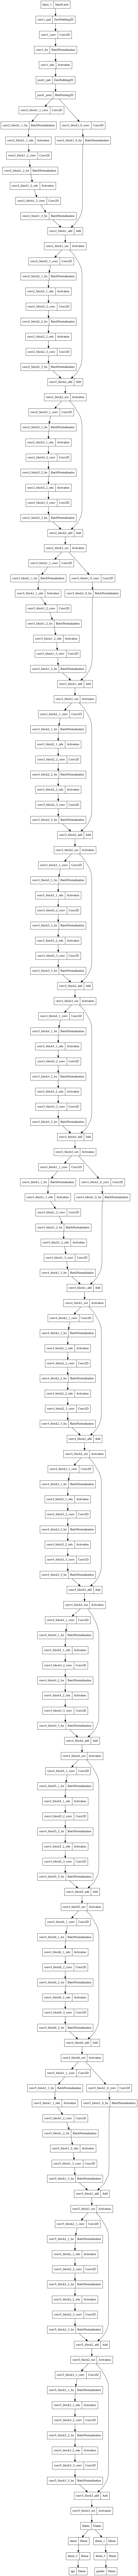

In [22]:
plot_model(model)

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [24]:
model.compile(optimizer="adam",loss={"age":"mse","gender":"binary_crossentropy"},metrics={"age":"mse","gender":"accuracy"})

In [25]:
model.fit(train_generator,epochs=2,batch_size=32,validation_data=test_generator)

Epoch 1/2
625/625 [==============================] - 226s 345ms/step - loss: 416.1294 - age_loss: 415.3088 - gender_loss: 0.8204 - age_mse: 415.3088 - gender_accuracy: 0.5136 - val_loss: 444.6548 - val_age_loss: 443.9635 - val_gender_loss: 0.6914 - val_age_mse: 443.9635 - val_gender_accuracy: 0.5326
Epoch 2/2
625/625 [==============================] - 207s 332ms/step - loss: 392.0954 - age_loss: 391.3987 - gender_loss: 0.6965 - age_mse: 391.3987 - gender_accuracy: 0.5206 - val_loss: 376.1411 - val_age_loss: 375.4495 - val_gender_loss: 0.6915 - val_age_mse: 375.4495 - val_gender_accuracy: 0.5326


In [26]:
model.compile(optimizer="adam",loss={"age":"mse","gender":"binary_crossentropy"},metrics={"age":"mse","gender":"accuracy"},loss_weights={"age":1,"gender":99})

In [28]:
model.fit(train_generator,epochs=2,batch_size=32,validation_data=test_generator)

Epoch 1/2
625/625 [==============================] - 208s 333ms/step - loss: 449.7812 - age_loss: 381.1395 - gender_loss: 0.6934 - age_mse: 381.1395 - gender_accuracy: 0.5215 - val_loss: 424.8719 - val_age_loss: 356.4305 - val_gender_loss: 0.6913 - val_age_mse: 356.4305 - val_gender_accuracy: 0.5324
Epoch 2/2
625/625 [==============================] - 208s 332ms/step - loss: 443.4053 - age_loss: 374.5920 - gender_loss: 0.6951 - age_mse: 374.5920 - gender_accuracy: 0.5189 - val_loss: 414.1214 - val_age_loss: 345.6762 - val_gender_loss: 0.6914 - val_age_mse: 345.6762 - val_gender_accuracy: 0.5324
